In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import streamlit as st
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()


%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
# !pip install lightgbm

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import h5py
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
pd.set_option('display.max_columns', None) # This will display maximum 500 columns
pd.set_option('display.max_rows', None)

In [3]:
def load_df(csv_path=r'train.csv/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [103]:
train_df = load_df()

Loaded train.csv. Shape: (903653, 55)


In [104]:
# Extract the part after the dot in each column name
train_df.columns = [col.split('.')[-1] for col in train_df.columns]

In [105]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,criteriaParameters,isTrueDirect,referralPath,page,slot,gclId,adNetworkType,isVideoAd,adContent,campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,google 

In [106]:
train_df.operatingSystem.unique()

array(['Windows', 'Macintosh', 'Linux', 'Android', 'iOS', 'Chrome OS',
       'BlackBerry', '(not set)', 'Samsung', 'Windows Phone', 'Xbox',
       'Nintendo Wii', 'Firefox OS', 'Nintendo WiiU', 'FreeBSD', 'Nokia',
       'NTT DoCoMo', 'Nintendo 3DS', 'SunOS', 'OpenBSD'], dtype=object)

In [107]:
train_df['city'].unique()

array(['Izmir', 'not available in demo dataset', 'Madrid', 'Brisbane',
       'Karachi', 'Paris', 'Singapore', 'Buenos Aires', '(not set)',
       'Bangkok', 'Jakarta', 'Bengaluru', 'London', 'Amsterdam', 'Moscow',
       'Kolkata', 'Seoul', 'Santiago', 'Warsaw', 'Dublin', 'Mexico City',
       'Barcelona', 'Sao Paulo', 'Mountain View', 'Istanbul', 'Dubai',
       'New Delhi', 'Sydney', 'New York', 'Rio de Janeiro', 'Hyderabad',
       'Toronto', 'Washington', 'Los Angeles', 'Pune', 'San Francisco',
       'Seattle', 'Palo Alto', 'Santa Clara', 'Mumbai', 'Colombo', 'Rome',
       'Chicago', 'Nairobi', 'Boston', 'Tel Aviv-Yafo', 'La Victoria',
       'Sunnyvale', 'Ann Arbor', 'San Jose', 'Austin', 'Pittsburgh',
       'Montreal', 'Cupertino', 'Salem', 'Ho Chi Minh City', 'Hanoi',
       'Tunis', 'Monterrey', 'Ankara', 'Quezon City', 'Budapest',
       'Minato', 'Dallas', 'Vancouver', 'Kirkland', 'Yokohama',
       'Stockholm', 'Tigard', 'Fremont', 'Boulder', 'Munich', 'Chennai',
       

In [108]:
train_df['city'].replace('not available in demo dataset',np.nan,inplace=True)

In [109]:
train_df['region'].unique()

array(['Izmir', 'not available in demo dataset', 'Community of Madrid',
       'Queensland', 'Sindh', 'Ile-de-France', '(not set)',
       'Buenos Aires', 'Bangkok', 'Jakarta', 'Karnataka', 'England',
       'North Holland', 'Moscow', 'West Bengal', 'Seoul',
       'Santiago Metropolitan Region', 'Masovian Voivodeship',
       'Dublin City', 'Mexico City', 'Catalonia', 'State of Sao Paulo',
       'California', 'Istanbul', 'Dubai', 'Delhi', 'New South Wales',
       'New York', 'State of Rio de Janeiro', 'Telangana', 'Ontario',
       'District of Columbia', 'Maharashtra', 'Washington', 'Lazio',
       'Illinois', 'Massachusetts', 'Tel Aviv District', 'Lima Region',
       'Michigan', 'Taipei City', 'Texas', 'Pennsylvania', 'Quebec',
       'Virginia', 'Ho Chi Minh', 'Hanoi', 'Nuevo Leon', 'Ankara',
       'Metro Manila', 'Budapest', 'Tokyo', 'British Columbia',
       'Kanagawa Prefecture', 'County Dublin', 'Stockholm County',
       'Oregon', 'Colorado', 'Bavaria', 'Tamil Nadu', 'Kyi

In [110]:
train_df['region'].replace('not available in demo dataset',np.nan,inplace=True)

In [111]:
train_df['metro'].unique()

array(['(not set)', 'not available in demo dataset', 'London',
       'San Francisco-Oakland-San Jose CA', 'New York NY',
       'Washington DC (Hagerstown MD)', 'Los Angeles CA',
       'Seattle-Tacoma WA', 'Chicago IL', 'Boston MA-Manchester NH',
       'Detroit MI', 'Austin TX', 'Pittsburgh PA', 'Roanoke-Lynchburg VA',
       'Dallas-Ft. Worth TX', 'Portland OR', 'Denver CO', 'Houston TX',
       'Atlanta GA', 'San Diego CA', 'Phoenix AZ', 'Columbus OH',
       'Charlotte NC', 'Jacksonville FL',
       'Meridian (exc. Channel Islands)', 'Midlands', 'Las Vegas NV',
       'La Crosse-Eau Claire WI', 'Springfield-Holyoke MA',
       'Green Bay-Appleton WI', 'San Antonio TX', 'North West',
       'Minneapolis-St. Paul MN', 'Philadelphia PA', 'Indianapolis IN',
       'Chico-Redding CA', 'Orlando-Daytona Beach-Melbourne FL',
       'Norfolk-Portsmouth-Newport News VA', 'Miami-Ft. Lauderdale FL',
       'JP_KANTO', 'Central Scotland', 'Omaha NE',
       'Tampa-St. Petersburg (Sarasota) FL

In [112]:
train_df['metro'].replace('not available in demo dataset',np.nan,inplace=True)

In [113]:
train_df.isna().sum()

channelGrouping                   0
date                              0
fullVisitorId                     0
sessionId                         0
socialEngagementType              0
visitId                           0
visitNumber                       0
visitStartTime                    0
browser                           0
browserVersion                    0
browserSize                       0
operatingSystem                   0
operatingSystemVersion            0
isMobile                          0
mobileDeviceBranding              0
mobileDeviceModel                 0
mobileInputSelector               0
mobileDeviceInfo                  0
mobileDeviceMarketingName         0
flashVersion                      0
language                          0
screenColors                      0
screenResolution                  0
deviceCategory                    0
continent                         0
subContinent                      0
country                           0
region                      

In [114]:
train_df.deviceCategory.unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [115]:
train_df.medium.value_counts()

medium
organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: count, dtype: int64

In [116]:
train_df['medium'].replace('(none)',np.nan,inplace=True)

In [117]:
train_df['medium'].replace('(not set)',np.nan,inplace=True)

In [118]:
train_df.medium.value_counts()

medium
organic      381561
referral     330955
cpc           25326
affiliate     16403
cpm            6262
Name: count, dtype: int64

In [119]:
# Value counts of non-null categories
value_counts = train_df['medium'].value_counts()

# Calculate the proportion of each category
proportions = value_counts / value_counts.sum()

# Number of null values
num_nulls = train_df['medium'].isnull().sum()

# Sample from categories based on their proportions to fill null values
fill_values = np.random.choice(proportions.index, size=num_nulls, p=proportions.values)

# Fill the null values with the sampled categories
train_df.loc[train_df['medium'].isnull(), 'medium'] = fill_values

In [120]:
train_df.medium.value_counts()

medium
organic      453293
referral     393282
cpc           30090
affiliate     19543
cpm            7445
Name: count, dtype: int64

In [121]:
train_df.isna().sum()

channelGrouping                   0
date                              0
fullVisitorId                     0
sessionId                         0
socialEngagementType              0
visitId                           0
visitNumber                       0
visitStartTime                    0
browser                           0
browserVersion                    0
browserSize                       0
operatingSystem                   0
operatingSystemVersion            0
isMobile                          0
mobileDeviceBranding              0
mobileDeviceModel                 0
mobileInputSelector               0
mobileDeviceInfo                  0
mobileDeviceMarketingName         0
flashVersion                      0
language                          0
screenColors                      0
screenResolution                  0
deviceCategory                    0
continent                         0
subContinent                      0
country                           0
region                      

In [122]:
train_df.country.value_counts()

country
United States               364744
India                        51140
United Kingdom               37393
Canada                       25869
Vietnam                      24598
Turkey                       20522
Thailand                     20123
Germany                      19980
Brazil                       19783
Japan                        19731
France                       15832
Mexico                       13225
Taiwan                       12996
Australia                    12698
Russia                       11662
Spain                        11658
Netherlands                  11453
Italy                        11332
Poland                        9693
Indonesia                     9273
Philippines                   9244
Singapore                     7172
Ireland                       6493
Malaysia                      6439
Romania                       6428
Ukraine                       5577
Israel                        5563
Peru                          5546
Sweden      

In [123]:
train_df.country.replace('(not set)',np.nan,inplace=True)

In [124]:
train_df.country.fillna(train_df.country.mode()[0],inplace=True)

In [125]:
# Step 1: Calculate the counts of each country
country_counts = train_df['country'].value_counts()

# Step 2: Create a mapping for countries with counts less than 90 to "Others"
country_mapping = country_counts[country_counts >= 90].index.to_list()
train_df['country'] = train_df['country'].apply(lambda x: x if x in country_mapping else 'Others')

In [126]:
train_df.country.value_counts()

country
United States           366212
India                    51140
United Kingdom           37393
Canada                   25869
Vietnam                  24598
Turkey                   20522
Thailand                 20123
Germany                  19980
Brazil                   19783
Japan                    19731
France                   15832
Mexico                   13225
Taiwan                   12996
Australia                12698
Russia                   11662
Spain                    11658
Netherlands              11453
Italy                    11332
Poland                    9693
Indonesia                 9273
Philippines               9244
Singapore                 7172
Ireland                   6493
Malaysia                  6439
Romania                   6428
Ukraine                   5577
Israel                    5563
Peru                      5546
Sweden                    5315
South Korea               5237
Argentina                 5037
Colombia                  4880


In [127]:
train_df.continent.value_counts()

continent
Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: count, dtype: int64

In [128]:
train_df.continent.replace('(not set)',np.nan,inplace=True)

In [129]:
train_df.continent.fillna(train_df.continent.mode()[0],inplace=True)

In [130]:
train_df.subContinent.replace('(not set)',np.nan,inplace=True)

In [131]:
train_df.subContinent.fillna(train_df.continent.mode()[0],inplace=True)

### EDA

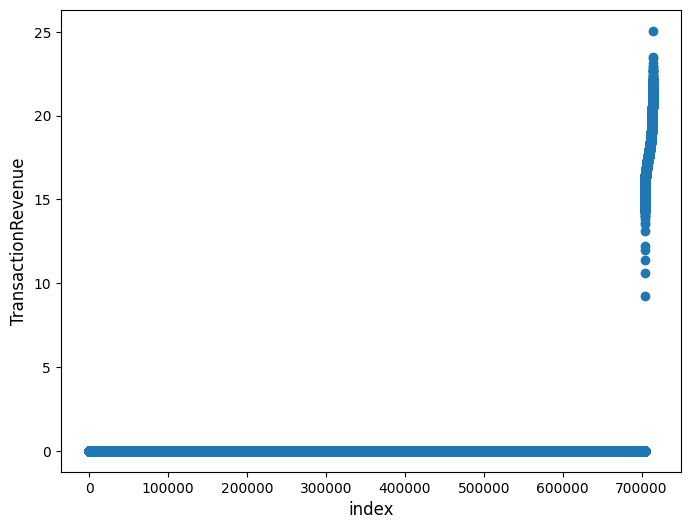

In [40]:
train_df["transactionRevenue"] = train_df["transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

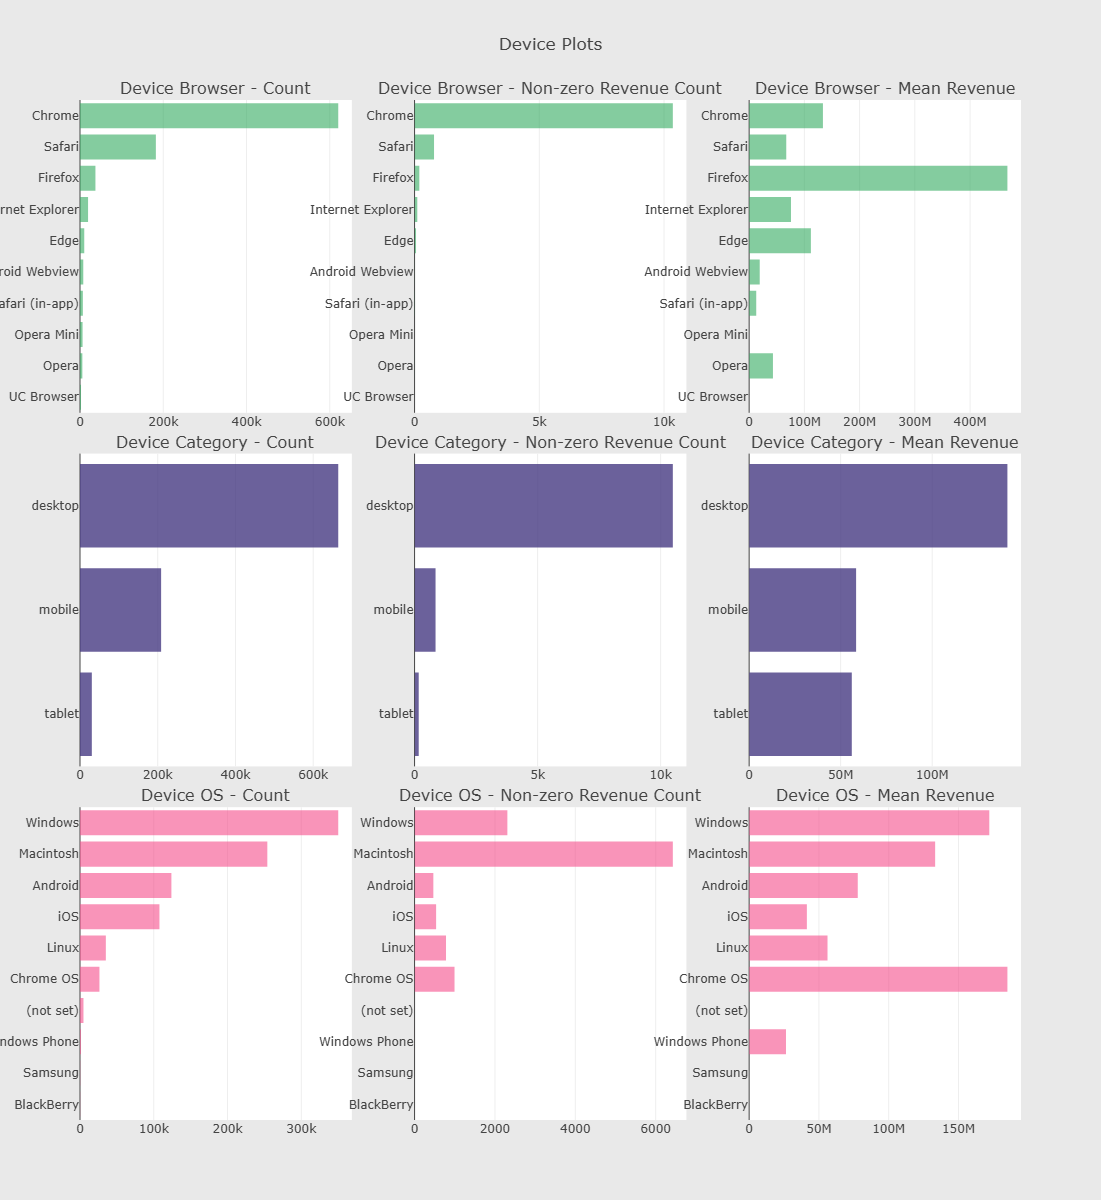

In [41]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('browser')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('deviceCategory')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('operatingSystem')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1100, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

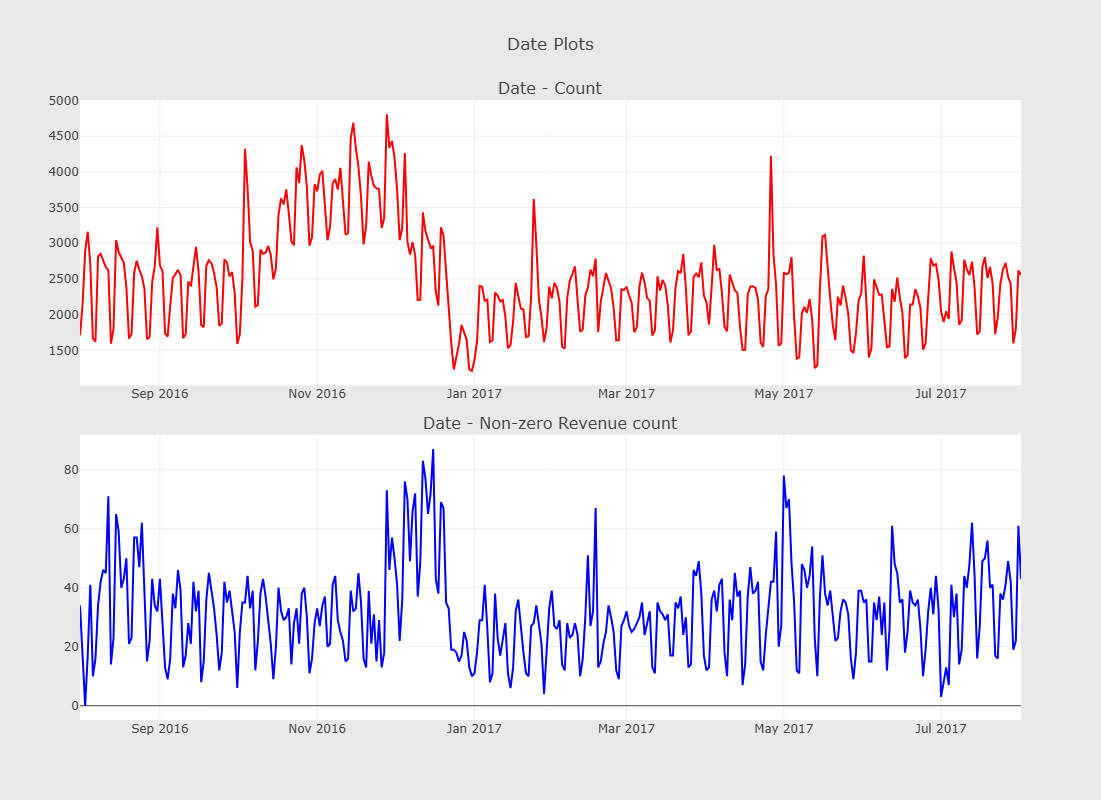

In [42]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

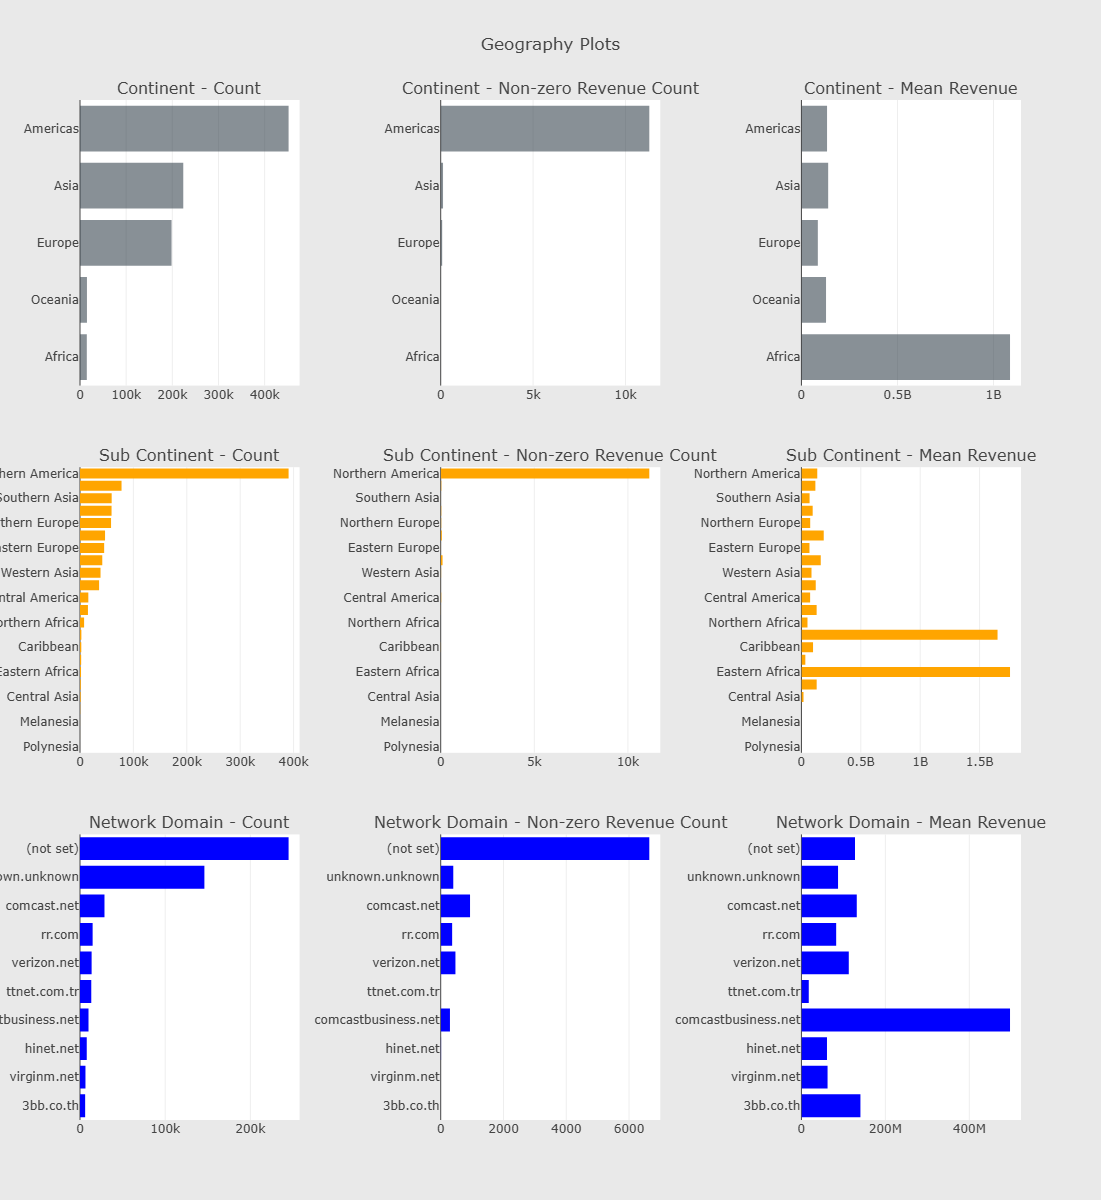

In [43]:
# Continent
cnt_srs = train_df.groupby('continent')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('subContinent')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('networkDomain')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])



fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1100, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

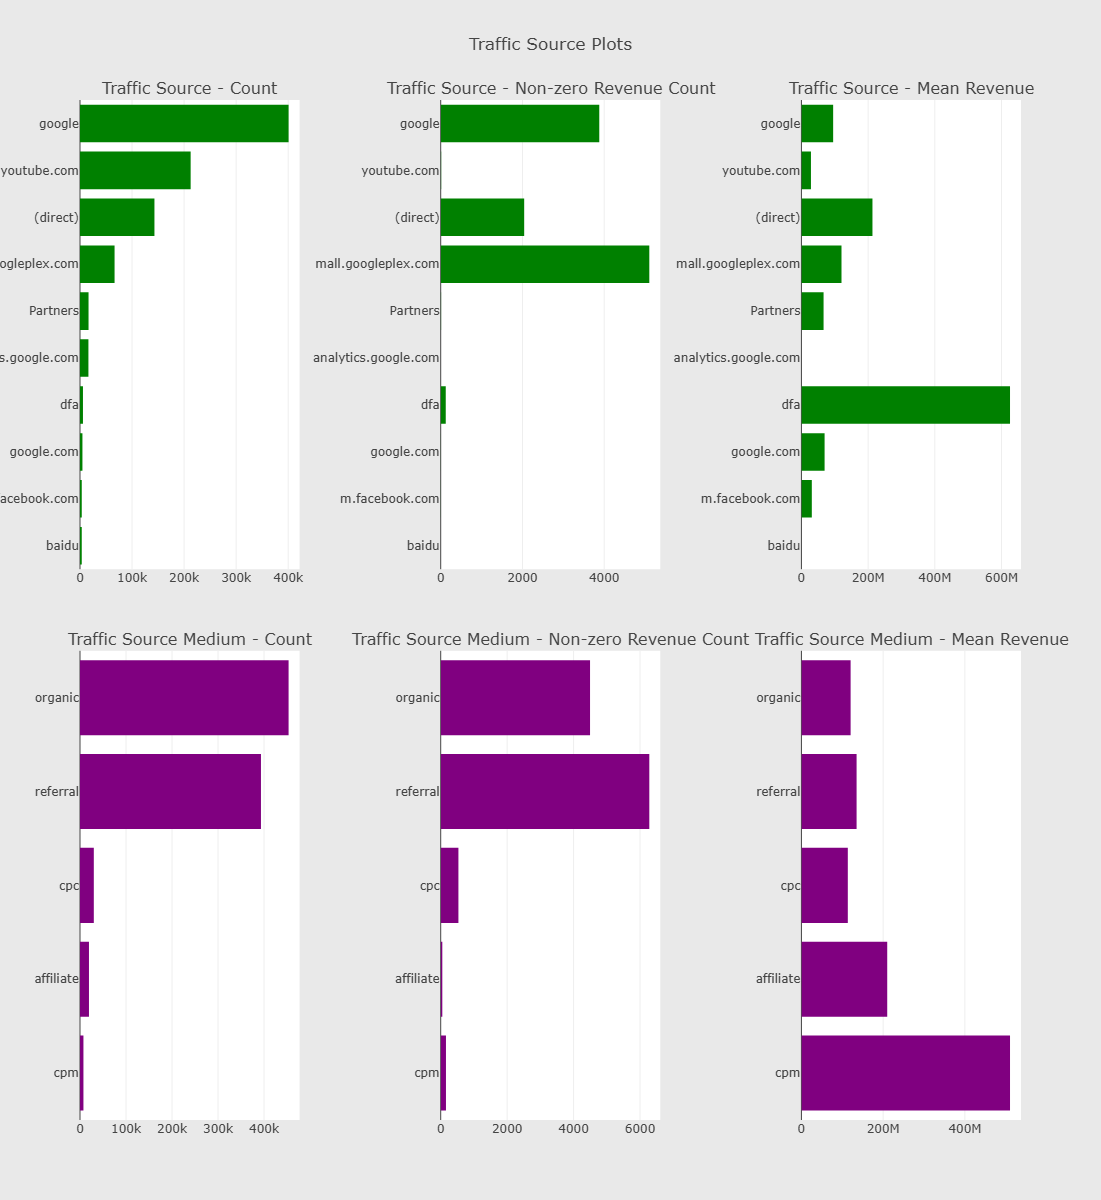

In [44]:
# Continent
cnt_srs = train_df.groupby('source')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('medium')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=1100, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

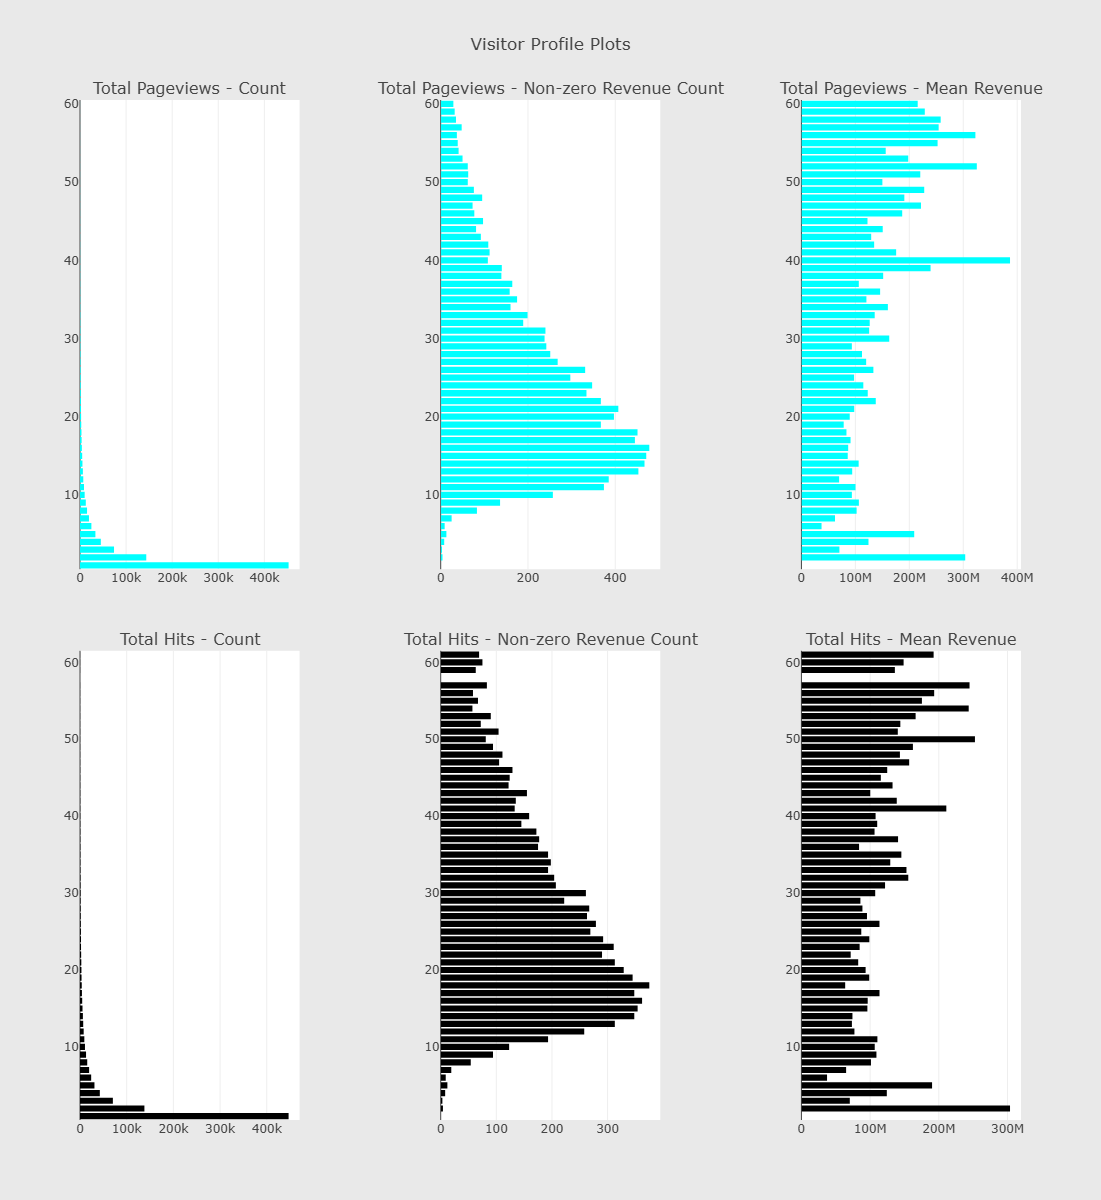

In [45]:
# Page views
cnt_srs = train_df.groupby('pageviews')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('hits')['transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')


# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

In [46]:
train_df['transactionRevenue']=np.log(train_df['transactionRevenue'])

Transaction Revenue Min Value:  9.210340371976184
Transaction Revenue Mean Value:  17.82336225511996
Transaction Revenue Median Value:  17.716472616032995
Transaction Revenue Max Value:  23.864374696008422


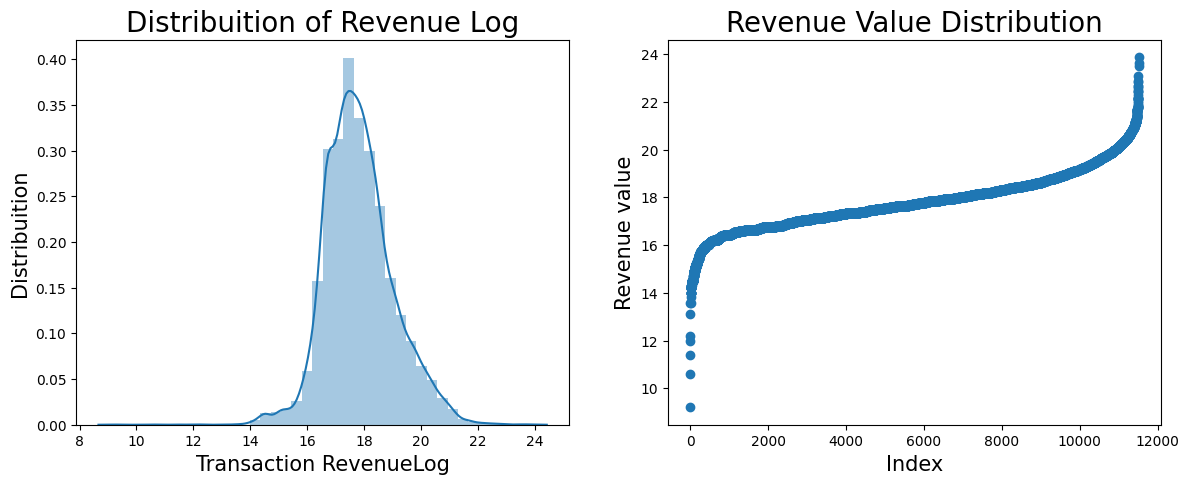

In [47]:
# Printing some statistics of our data
print("Transaction Revenue Min Value: ", 
      train_df[train_df['transactionRevenue'] > 0]["transactionRevenue"].min()) # printing the min value
print("Transaction Revenue Mean Value: ", 
      train_df[train_df['transactionRevenue'] > 0]["transactionRevenue"].mean()) # mean value
print("Transaction Revenue Median Value: ", 
      train_df[train_df['transactionRevenue'] > 0]["transactionRevenue"].median()) # median value
print("Transaction Revenue Max Value: ", 
      train_df[train_df['transactionRevenue'] > 0]["transactionRevenue"].max()) # the max value

# It I did to plot the quantiles but are not working
#print(round(df_train['totals.transactionRevenue'].quantile([.025,.25,.5,.75,.975]),2))

# seting the figure size of our plots
plt.figure(figsize=(14,5))

# Subplot allow us to plot more than one 
# in this case, will be create a subplot grid of 2 x 1
plt.subplot(1,2,1)
# seting the distribuition of our data and normalizing using np.log on values highest than 0 and + 
# also, we will set the number of bins and if we want or not kde on our histogram
ax = sns.distplot((train_df[train_df['transactionRevenue'] > 0]["transactionRevenue"] + 0.01), bins=40, kde=True)
ax.set_xlabel('Transaction RevenueLog', fontsize=15) #seting the xlabel and size of font
ax.set_ylabel('Distribuition', fontsize=15) #seting the ylabel and size of font
ax.set_title("Distribuition of Revenue Log", fontsize=20) #seting the title and size of font

# setting the second plot of our grid of graphs
plt.subplot(1,2,2)
# ordering the total of users and seting the values of transactions to understanding 
plt.scatter(range(train_df.shape[0]), np.sort((train_df['transactionRevenue'].values)))
plt.xlabel('Index', fontsize=15) # xlabel and size of words
plt.ylabel('Revenue value', fontsize=15) # ylabel and size of words
plt.title("Revenue Value Distribution", fontsize=20) # Setting Title and fontsize

plt.show()

## Feature Enginerring

In [48]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'browserVersion',
 'browserSize',
 'operatingSystemVersion',
 'mobileDeviceBranding',
 'mobileDeviceModel',
 'mobileInputSelector',
 'mobileDeviceInfo',
 'mobileDeviceMarketingName',
 'flashVersion',
 'language',
 'screenColors',
 'screenResolution',
 'cityId',
 'latitude',
 'longitude',
 'networkLocation',
 'visits',
 'criteriaParameters']

In [49]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["campaignCode"], axis=1)

In [50]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,region,metro,city,networkDomain,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,isTrueDirect,referralPath,page,slot,gclId,adNetworkType,isVideoAd,adContent
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,NaN,NaN,NaN,dodo.net.au,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,NaN,NaN,NaN,unknown.unknown,1,1,1,1,NaN,(not set),google,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,NaN,NaN,NaN,unknown.unknown,1,1,1,NaN,NaN,(not set),google,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
(train_df.isna().mean()*100)

channelGrouping        0.000000
date                   0.000000
fullVisitorId          0.000000
visitId                0.000000
visitNumber            0.000000
visitStartTime         0.000000
browser                0.000000
operatingSystem        0.000000
isMobile               0.000000
deviceCategory         0.000000
continent              0.000000
subContinent           0.000000
country                0.000000
region                56.241610
metro                 56.241610
city                  56.241610
networkDomain          0.000000
hits                   0.000000
pageviews              0.011066
bounces               50.132407
newVisits             22.198012
transactionRevenue    98.725728
campaign               0.000000
source                 0.000000
medium                 0.000000
keyword               55.655102
isTrueDirect          69.678073
referralPath          63.377425
page                  97.625195
slot                  97.625195
gclId                 97.614018
adNetwor

In [52]:
col=['region','metro','city','keyword','isTrueDirect','referralPath','page','slot','gclId',
     'adNetworkType','isVideoAd','adContent','networkDomain','source']

In [53]:
train_df.drop(col,axis=1,inplace=True)

In [54]:
train_df.isna().mean()*100

channelGrouping        0.000000
date                   0.000000
fullVisitorId          0.000000
visitId                0.000000
visitNumber            0.000000
visitStartTime         0.000000
browser                0.000000
operatingSystem        0.000000
isMobile               0.000000
deviceCategory         0.000000
continent              0.000000
subContinent           0.000000
country                0.000000
hits                   0.000000
pageviews              0.011066
bounces               50.132407
newVisits             22.198012
transactionRevenue    98.725728
campaign               0.000000
medium                 0.000000
dtype: float64

In [55]:
# Impute 0 for missing target values
train_df["transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
# test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "browser", 
            "deviceCategory", "operatingSystem", 
             "continent", 
            "country", 
            "subContinent",    
             "campaign",
             "medium", 
             ]
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    # test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


num_cols = ["hits", "pageviews", "visitNumber", "visitStartTime", 'bounces',  'newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    # test_df[col] = test_df[col].astype(float)

channelGrouping
browser
deviceCategory
operatingSystem
continent
country
subContinent
campaign
medium


In [56]:
train_df.isna().sum()

channelGrouping            0
date                       0
fullVisitorId              0
visitId                    0
visitNumber                0
visitStartTime             0
browser                    0
operatingSystem            0
isMobile                   0
deviceCategory             0
continent                  0
subContinent               0
country                    0
hits                       0
pageviews                100
bounces               453023
newVisits             200593
transactionRevenue         0
campaign                   0
medium                     0
dtype: int64

In [57]:
train_df['pageviews'].fillna(train_df['pageviews'].median(),inplace=True)
train_df['bounces'].fillna(train_df['bounces'].median(),inplace=True)
train_df['newVisits'].fillna(train_df['newVisits'].median(),inplace=True)

In [58]:
train_df.isna().sum()

channelGrouping       0
date                  0
fullVisitorId         0
visitId               0
visitNumber           0
visitStartTime        0
browser               0
operatingSystem       0
isMobile              0
deviceCategory        0
continent             0
subContinent          0
country               0
hits                  0
pageviews             0
bounces               0
newVisits             0
transactionRevenue    0
campaign              0
medium                0
dtype: int64

In [59]:
## Removing Date Full visitor ID,visitId because it will not give any information about data
col=['date','fullVisitorId','visitId']
train_df.drop(col,axis=1,inplace=True)

In [60]:
### To convert Data type of columns into float for revenue and also apply log because revenue is skewd data and 
# high range values
train_df['isMobile']=train_df['isMobile'].astype(int)
# train_df['transactionRevenue']=np.log1p(train_df['transactionRevenue'].astype(float))

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   channelGrouping     903653 non-null  int32  
 1   visitNumber         903653 non-null  float64
 2   visitStartTime      903653 non-null  float64
 3   browser             903653 non-null  int32  
 4   operatingSystem     903653 non-null  int32  
 5   isMobile            903653 non-null  int32  
 6   deviceCategory      903653 non-null  int32  
 7   continent           903653 non-null  int32  
 8   subContinent        903653 non-null  int32  
 9   country             903653 non-null  int32  
 10  hits                903653 non-null  float64
 11  pageviews           903653 non-null  float64
 12  bounces             903653 non-null  float64
 13  newVisits           903653 non-null  float64
 14  transactionRevenue  903653 non-null  float64
 15  campaign            903653 non-nul

In [62]:
train_df.drop('channelGrouping',axis=1,inplace=True)

In [63]:
train_df.drop('campaign',axis=1,inplace=True)

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
## Split Data into train and test
x=train_df.drop(['transactionRevenue','visitStartTime'],axis=1)
y=train_df['transactionRevenue']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.70,random_state=2)

In [66]:
## Model building
# custom function to run light gbm model
def run_lgb(x_train,y_train,x_test,y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

    lgtrain = lgb.Dataset(x_train, label=y_train)
    lgval = lgb.Dataset(x_test, label=y_test)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval])
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y,model

# Training the model #
pred_test, model = run_lgb(x_train, y_train, x_test, y_test)

In [67]:
## Train data evaluation 
from sklearn.metrics import mean_squared_error
y_train_pred=model.predict(x_train)
mse=mean_squared_error(y_train,y_train_pred)
rmse=np.sqrt(mse)
print(rmse)


1.539109390948733


In [68]:
## Test Data Evaluation
from sklearn.metrics import mean_squared_error,r2_score
mse=mean_squared_error(y_test,pred_test)
rmse=np.sqrt(mse)
r2=r2_score(y_test,pred_test)
print(rmse)

1.6856155812395748


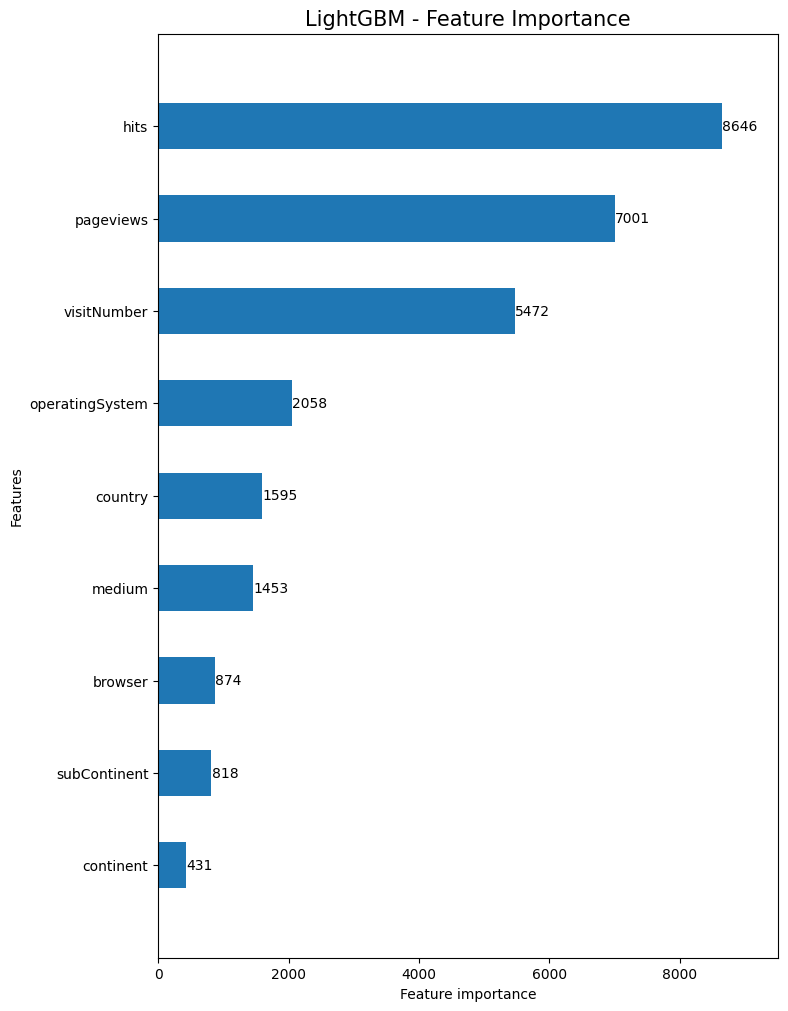

In [69]:
fig, ax = plt.subplots(figsize=(8,12))
lgb.plot_importance(model, max_num_features=9, height=0.5, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [70]:
train_df.operatingSystem.unique()

array([16,  7,  6,  1, 19,  3,  2,  0, 14, 17, 18, 10,  4, 11,  5, 12,  8,
        9, 15, 13])

In [71]:
train_df.medium.unique()

array([3, 4, 1, 0, 2])

In [72]:
train_df.browser.unique()

array([11, 16, 46, 20, 40, 15, 37, 36,  8, 41, 12, 31,  2, 28,  3, 49,  6,
       38, 34, 29, 33,  4, 25, 19, 45, 24, 30, 52, 35, 21, 50,  0, 23, 26,
        5,  7, 42, 22, 43, 10, 51, 27, 32, 17, 13, 14, 53, 48, 47,  1, 18,
       39, 44,  9])

In [73]:
train_df.subContinent.unique()

array([21,  1, 19, 16, 13, 18, 22, 15,  6,  7, 12, 20,  3,  5,  0,  2, 17,
       11,  4, 10,  8,  9, 14])

In [74]:
train_df.continent.unique()

array([2, 4, 3, 1, 0])

In [75]:
col=['hits','pageviews','visitNumber','operatingSystem','country','browser','subContinent','medium','transactionRevenue','continent']

In [76]:
df2=train_df[col]

In [77]:
df2.head()

,hits,pageviews,visitNumber,operatingSystem,country,browser,subContinent,medium,transactionRevenue,continent
0,1.0,1.0,1.0,16,114,11,21,3,0.0,2
1,1.0,1.0,1.0,7,4,16,1,3,0.0,4
2,1.0,1.0,1.0,16,104,11,19,3,0.0,3
3,1.0,1.0,1.0,6,46,46,16,3,0.0,2
4,1.0,1.0,2.0,1,118,11,13,3,0.0,3


In [78]:
df2.shape

(903653, 10)

In [83]:
df2.corr()

,hits,pageviews,visitNumber,operatingSystem,country,browser,subContinent,medium,transactionRevenue,continent
hits,1.000000,0.983204,0.041317,-0.052023,0.101338,-0.075134,-0.062227,-0.035082,0.378804,-0.135828
pageviews,0.983204,1.000000,0.043338,-0.054080,0.108537,-0.078562,-0.065990,-0.037712,0.400734,-0.145281
visitNumber,0.041317,0.043338,1.000000,0.007864,0.051683,-0.042932,-0.025524,-0.021382,0.023666,-0.065677
operatingSystem,-0.052023,-0.054080,0.007864,1.000000,-0.058358,0.183733,-0.022073,-0.034057,-0.040621,0.101582
country,0.101338,0.108537,0.051683,-0.058358,1.000000,-0.003006,-0.138588,-0.028862,0.080329,-0.351312
browser,-0.075134,-0.078562,-0.042932,0.183733,-0.003006,1.000000,0.031845,0.040744,-0.045807,0.040624
subContinent,-0.062227,-0.065990,-0.025524,-0.022073,-0.138588,0.031845,1.000000,0.032810,-0.031715,0.192114
medium,-0.035082,-0.037712,-0.021382,-0.034057,-0.028862,0.040744,0.032810,1.000000,0.018372,0.016311
transactionRevenue,0.378804,0.400734,0.023666,-0.040621,0.080329,-0.045807,-0.031715,0.018372,1.000000,-0.089293
continent,-0.135828,-0.145281,-0.065677,0.101582,-0.351312,0.040624,0.192114,0.016311,-0.089293,1.000000


In [80]:
col=['operatingSystem','country','browser','subContinent','medium','transactionRevenue','continent']

In [81]:
df2[col].corr('kendall')

,operatingSystem,country,browser,subContinent,medium,transactionRevenue,continent
operatingSystem,1.000000,-0.045256,0.284178,-0.011734,-0.057464,-0.034852,0.076724
country,-0.045256,1.000000,-0.025008,-0.210705,-0.021375,0.086067,-0.415773
browser,0.284178,-0.025008,1.000000,0.039368,0.027131,-0.045113,0.063274
subContinent,-0.011734,-0.210705,0.039368,1.000000,0.038196,-0.046180,0.350213
medium,-0.057464,-0.021375,0.027131,0.038196,1.000000,0.022337,0.014167
transactionRevenue,-0.034852,0.086067,-0.045113,-0.046180,0.022337,1.000000,-0.089985
continent,0.076724,-0.415773,0.063274,0.350213,0.014167,-0.089985,1.000000


In [82]:
x=df2.country.value_counts()

In [71]:
x.head()

,visitNumber,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,hits,pageviews,bounces,newVisits,medium
0,1.0,11,16,0,0,2,21,114,1.0,1.0,1.0,1.0,3
1,1.0,16,7,0,0,4,1,4,1.0,1.0,1.0,1.0,3
2,1.0,11,16,0,0,3,19,104,1.0,1.0,1.0,1.0,3
3,1.0,46,6,0,0,2,16,46,1.0,1.0,1.0,1.0,3
4,2.0,11,1,1,1,3,13,118,1.0,1.0,1.0,1.0,3


In [84]:
## Split Data into train and test
x=df2.drop(['transactionRevenue'],axis=1)
y=df2['transactionRevenue']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.70,random_state=2)

In [85]:
## Model building
# custom function to run light gbm model
def run_lgb(x_train,y_train,x_test,y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

    lgtrain = lgb.Dataset(x_train, label=y_train)
    lgval = lgb.Dataset(x_test, label=y_test)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval])
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y,model

# Training the model #
pred_test, model = run_lgb(x_train, y_train, x_test, y_test)

In [86]:
## Test Data Evaluation
from sklearn.metrics import mean_squared_error,r2_score
mse=mean_squared_error(y_test,pred_test)
rmse=np.sqrt(mse)
r2=r2_score(y_test,pred_test)
print(rmse)

1.6851406468582553


In [112]:
# model.save_model('train_model_1.h5')

## Random Forest

##### Hyperparameter Tunning

In [87]:


rf_reg = RandomForestRegressor(random_state=4) # random_state >> bootstrapping

hyp = {
    "n_estimators" : np.arange(10,100), # 230
    "max_depth" : np.arange(2,10),
    "min_samples_split" : np.arange(2,20),
    "min_samples_leaf" : np.arange(2,10),
    "max_features" :['auto','log2'],
    "bootstrap": [True],
    "oob_score" : [False],
}

rscv_rf_model = RandomizedSearchCV(rf_reg,hyp, cv= 3)
rscv_rf_model.fit(x_train, x_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=4),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99]),
                                        'oob_score': [False]})

In [88]:
rscv_rf_model.best_estimator_

RandomForestRegressor(max_depth=8, max_features='log2', min_samples_leaf=6,
                      min_samples_split=3, n_estimators=33, random_state=4)

In [90]:
rf_reg=RandomForestRegressor(max_depth=9, max_features='log2', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=53, random_state=4)
rf_reg.fit(x_train, y_train)

RandomForestRegressor(max_depth=9, max_features='log2', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=53, random_state=4)

In [91]:
## Test data
y_pred=rf_reg.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print(f'The rmse is {rmse}')

The rmse is 1.6780351335249215


In [92]:
# Get feature importances
importances = rf_reg.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': x_train.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

           Feature  Importance
1        pageviews    0.460104
0             hits    0.265918
2      visitNumber    0.080971
4          country    0.068163
8        continent    0.034464
3  operatingSystem    0.031105
7           medium    0.030135
5          browser    0.014638
6     subContinent    0.014501


In [96]:
df2.head()

,hits,pageviews,visitNumber,operatingSystem,country,browser,subContinent,medium,transactionRevenue,continent
0,1.0,1.0,1.0,16,114,11,21,3,0.0,2
1,1.0,1.0,1.0,7,4,16,1,3,0.0,4
2,1.0,1.0,1.0,16,104,11,19,3,0.0,3
3,1.0,1.0,1.0,6,46,46,16,3,0.0,2
4,1.0,1.0,2.0,1,118,11,13,3,0.0,3


In [93]:
## Split Data into train and test
x=df2.drop(['transactionRevenue'],axis=1)
y=df2['transactionRevenue']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.70,random_state=2)

In [94]:
rf_reg=RandomForestRegressor(max_depth=9, max_features='log2', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=53, random_state=4)
rf_reg.fit(x_train, y_train)

RandomForestRegressor(max_depth=9, max_features='log2', min_samples_leaf=3,
                      min_samples_split=5, n_estimators=53, random_state=4)

In [95]:
## Test data
y_pred=rf_reg.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print(f'The rmse is {rmse}')

The rmse is 1.6780351335249215


In [98]:
import pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_reg, file)

In [138]:
x_train.head()

,hits,pageviews,visitNumber,operatingSystem,country,browser,subContinent,medium,continent
314674,68.0,52.0,1.0,7,4,11,1,3,4
807866,3.0,3.0,3.0,7,37,11,22,4,3
273399,1.0,1.0,1.0,16,76,11,22,3,3
775753,1.0,1.0,1.0,16,45,11,18,0,2
624403,1.0,1.0,2.0,19,119,40,12,1,1


In [139]:
x_train.columns

Index(['hits', 'pageviews', 'visitNumber', 'operatingSystem', 'country',
       'browser', 'subContinent', 'medium', 'continent'],
      dtype='object')

In [137]:
# Save feature names
feature_names = ['hits', 'pageviews', 'visitNumber', 'operatingSystem', 'country',
       'browser', 'subContinent', 'medium', 'continent']
with open('feature_names.pkl', 'wb') as feature_file:
    pickle.dump(feature_names, feature_file)

# AdaBosst

In [99]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [100]:
ada =AdaBoostRegressor()

ada.fit(x_train, y_train)

AdaBoostRegressor()

In [101]:
y_pred=ada.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print(f'The rmse is {rmse}')

The rmse is 2.1765363959348583


### Model Saving

In [189]:
# model.save_model('train_model_1.h5')

In [189]:
train_df.head()


,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,continent,subContinent,country,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,medium
0,1.0,1.472830e+09,11,16,0,0,3,21,114,1.0,1.0,1.0,1.0,0.0,0,3
1,1.0,1.472880e+09,16,7,0,0,5,1,4,1.0,1.0,1.0,1.0,0.0,0,3
2,1.0,1.472865e+09,11,16,0,0,4,19,104,1.0,1.0,1.0,1.0,0.0,0,3
3,1.0,1.472881e+09,46,6,0,0,3,16,46,1.0,1.0,1.0,1.0,0.0,0,3
4,2.0,1.472823e+09,11,1,1,1,4,13,118,1.0,1.0,1.0,1.0,0.0,0,3


In [190]:
df=load_df()

Loaded train.csv. Shape: (903653, 55)


In [191]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [192]:
df[df['totals.transactionRevenue']!=np.nan].head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [193]:
# Extract the part after the dot in each column name
df.columns = [col.split('.')[-1] for col in df.columns]

In [194]:
df['transactionRevenue'].fillna(0,inplace=True)

In [195]:
df[df['transactionRevenue']!=0].head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,criteriaParameters,isTrueDirect,referralPath,page,slot,gclId,adNetworkType,isVideoAd,adContent,campaignCode
752,Direct,20160902,6194193421514403509,6194193421514403509_1472843572,Not Socially Engaged,1472843572,1,1472843572,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,11,11,NaN,1,37860000,(not set),(direct),(none),NaN,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,20160902,5327166854580374902,5327166854580374902_1472844906,Not Socially Engaged,1472844906,3,1472844906,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,11,10,NaN,NaN,306670000,(not set),google,organic,(not provided),not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,20160902,8885051388942907862,8885051388942907862_1472827393,Not Socially Engaged,1472827393,7,1472827393,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,13,11,NaN,NaN,68030000,(not set),mall.googleplex.com,referral,NaN,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,20160902,0185467632009737931,0185467632009737931_1472846398,Not Socially Engaged,1472846398,6,1472846398,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,13,12,NaN,NaN,26250000,(not set),mall.googleplex.com,referral,NaN,not available in demo dataset,

In [197]:
df['networkDomain'].unique()

array(['ttnet.com.tr', 'dodo.net.au', 'unknown.unknown', ...,
       'lumenis.com', 'malnet.ru', 'xpressgt.co.za'], dtype=object)

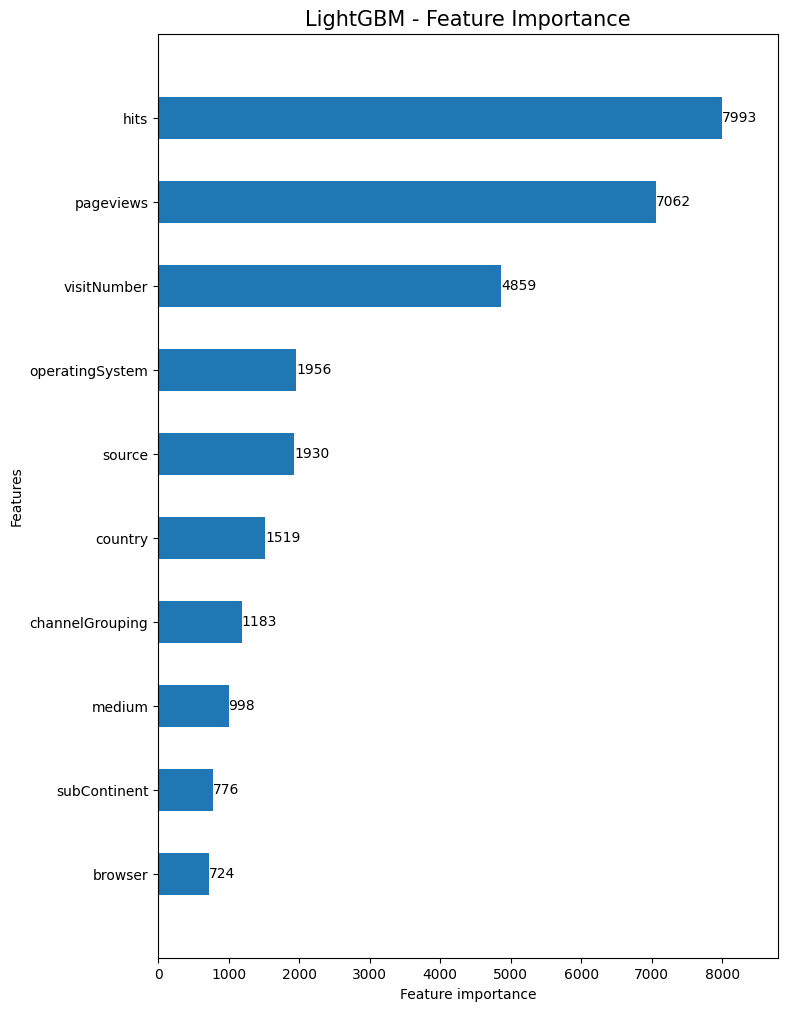

In [198]:
fig, ax = plt.subplots(figsize=(8,12))
lgb.plot_importance(model, max_num_features=10, height=0.5, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [102]:
from sklearn.preprocessing import LabelEncoder
import h5py
col=['operatingSystem','country','continent','campaign','browser','subContinent','medium']

In [133]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,criteriaParameters,isTrueDirect,referralPath,page,slot,gclId,adNetworkType,isVideoAd,adContent,campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,NaN,NaN,NaN,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Indonesia,NaN,NaN,NaN,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,google + online,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Soci

In [134]:
# Create and fit the encoders

country_encoder = LabelEncoder().fit(train_df.country)
continent_encoder = LabelEncoder().fit(train_df.continent)
operatingSystem_encoder = LabelEncoder().fit(train_df.operatingSystem)
campaign_encoder = LabelEncoder().fit(train_df.campaign)
subContinent_encoder = LabelEncoder().fit(train_df.subContinent)
medium_encoder=LabelEncoder().fit(train_df.medium)
browser_encoder=LabelEncoder().fit(train_df.browser)

# Save the encoders
encoders = {
    'operatingSystem':operatingSystem_encoder,
    'continent': continent_encoder,
    'country': country_encoder,
    'campaign': campaign_encoder,
    'browser': browser_encoder,
    'subContinent': subContinent_encoder,
    'medium': medium_encoder
}


In [136]:
import pickle
# Save the encoders to a pickle file
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(encoders, file)


In [41]:
# import h5py
# import numpy as np

# # Function to save encoders to HDF5
# def save_encoders_to_h5(encoders, file_path):
#     with h5py.File(file_path, 'w') as hf:
#         for feature, encoder in encoders.items():
#             # Create a dataset for each encoder's classes
#             hf.create_dataset(f'{feature}_classes', data=np.array(encoder.classes_))

# # Save the encoders
# save_encoders_to_h5(encoders, 'label_encoder_1.h5')


In [ ]:
df.medium.unique()

In [ ]:
np.where((df.medium=='(none)') | (df.medium=='(not set)'))[0]

In [ ]:
df.medium.value_counts()

In [ ]:
df.head()

In [ ]:
train_df[train_df.transactionRevenue>0.0].head()

In [109]:
fun(l)

[]

In [202]:
train_df.head()

,hits,pageviews,visitNumber,operatingSystem,country,source,channelGrouping,browser,subContinent,medium,transactionRevenue
0,1.0,1.0,1.0,16,204,149,4,11,21,3,0.0
1,1.0,1.0,1.0,7,12,149,4,16,1,3,0.0
2,1.0,1.0,1.0,16,181,149,4,11,19,3,0.0
3,1.0,1.0,1.0,6,94,149,4,46,16,3,0.0
4,1.0,1.0,2.0,1,211,149,4,11,13,3,0.0


In [203]:
train_df.corr()

,hits,pageviews,visitNumber,operatingSystem,country,source,channelGrouping,browser,subContinent,medium,transactionRevenue
hits,1.000000,0.983204,0.041317,-0.052023,0.101261,-0.082581,-0.067336,-0.075134,-0.062227,-0.035154,0.378804
pageviews,0.983204,1.000000,0.043338,-0.054080,0.108448,-0.087829,-0.070999,-0.078562,-0.065990,-0.037525,0.400734
visitNumber,0.041317,0.043338,1.000000,0.007864,0.051706,-0.047012,-0.036786,-0.042932,-0.025524,-0.021710,0.023666
operatingSystem,-0.052023,-0.054080,0.007864,1.000000,-0.059917,0.046174,0.036399,0.183733,-0.022073,-0.034199,-0.040621
country,0.101261,0.108448,0.051706,-0.059917,1.000000,-0.063249,-0.045022,-0.004469,-0.117587,-0.029898,0.080101
source,-0.082581,-0.087829,-0.047012,0.046174,-0.063249,1.000000,0.937980,0.128296,0.078173,0.488317,-0.010035
channelGrouping,-0.067336,-0.070999,-0.036786,0.036399,-0.045022,0.937980,1.000000,0.100722,0.062520,0.556682,-0.000807
browser,-0.075134,-0.078562,-0.042932,0.183733,-0.004469,0.128296,0.100722,1.000000,0.031845,0.040282,-0.045807
subContinent,-0.062227,-0.065990,-0.025524,-0.022073,-0.117587,0.078173,0.062520,0.031845,1.000000,0.033341,-0.031715
medium,-0.035154,-0.037525,-0.021710,-0.034199,-0.029898,0.488317,0.556682,0.040282,0.033341,1.000000,0.018236


In [204]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,criteriaParameters,isTrueDirect,referralPath,page,slot,gclId,adNetworkType,isVideoAd,adContent,campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,0,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,0,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,0,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,0,(not set),google,organic,google + online

In [205]:
df.country.unique()

array(['Turkey', 'Australia', 'Spain', 'Indonesia', 'United Kingdom',
       'Italy', 'Pakistan', 'Austria', 'Netherlands', 'India', 'France',
       'Brazil', 'China', 'Singapore', 'Argentina', 'Poland', 'Germany',
       'Canada', 'Thailand', 'Hungary', 'Malaysia', 'Denmark', 'Taiwan',
       'Russia', 'Nigeria', 'Belgium', 'South Korea', 'Chile', 'Ireland',
       'Philippines', 'Greece', 'Mexico', 'Montenegro', 'United States',
       'Bangladesh', 'Japan', 'Slovenia', 'Czechia', 'Sweden',
       'United Arab Emirates', 'Switzerland', 'Portugal', 'Peru',
       'Hong Kong', 'Vietnam', 'Sri Lanka', 'Serbia', 'Norway', 'Romania',
       'Kenya', 'Ukraine', 'Israel', 'Slovakia', '(not set)', 'Lithuania',
       'Puerto Rico', 'Bosnia & Herzegovina', 'Croatia', 'South Africa',
       'Paraguay', 'Botswana', 'Colombia', 'Uruguay', 'Algeria',
       'Finland', 'Guatemala', 'Egypt', 'Malta', 'Bulgaria',
       'New Zealand', 'Kuwait', 'Uzbekistan', 'Saudi Arabia', 'Cyprus',
       'Estoni

In [206]:
df.country.nunique()

222

In [207]:
df.channelGrouping.unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

In [208]:
df.browser.unique()

array(['Chrome', 'Firefox', 'UC Browser', 'Internet Explorer', 'Safari',
       'Edge', 'Opera Mini', 'Opera', 'BlackBerry', 'Safari (in-app)',
       'Coc Coc', 'Mozilla Compatible Agent', 'ADM', 'MRCHROME',
       'Amazon Silk', 'YaBrowser', 'Android Webview', 'Puffin',
       'Nokia Browser', 'Maxthon', 'Nintendo Browser', 'Android Browser',
       'Lunascape', 'IE with Chrome Frame', 'ThumbSniper',
       'LYF_LS_4002_12', 'Mozilla', 'osee2unifiedRelease', 'NokiaE52-1',
       'Iron', '[Use default User-agent string] LIVRENPOCHE', '(not set)',
       'LYF_LS_4002_11', 'M5', 'Android Runtime', 'Apple-iPhone7C2',
       'SeaMonkey', 'Konqueror', 'Seznam', 'Changa 99695759', 'no-ua',
       'MQQBrowser', 'Nichrome', 'HTC802t_TD', 'DASH_JR_3G', 'DoCoMo',
       'subjectAgent: NoticiasBoom', 'YE', 'User Agent', '0',
       'Hisense M20-M_LTE', 'Reddit', 'TCL P500M', 'CSM Click'],
      dtype=object)

In [214]:
x=df.browser.value_counts()

In [218]:
x[x>100].index

Index(['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge',
       'Android Webview', 'Safari (in-app)', 'Opera Mini', 'Opera',
       'UC Browser', 'YaBrowser', 'Coc Coc', 'Amazon Silk', 'Android Browser',
       'Mozilla Compatible Agent', 'MRCHROME', 'Maxthon', 'BlackBerry',
       'Nintendo Browser'],
      dtype='object', name='browser')

In [219]:
df.subContinent.unique()

array(['Western Asia', 'Australasia', 'Southern Europe', 'Southeast Asia',
       'Northern Europe', 'Southern Asia', 'Western Europe',
       'South America', 'Eastern Asia', 'Eastern Europe',
       'Northern America', 'Western Africa', 'Central America',
       'Eastern Africa', '(not set)', 'Caribbean', 'Southern Africa',
       'Northern Africa', 'Central Asia', 'Middle Africa', 'Melanesia',
       'Micronesian Region', 'Polynesia'], dtype=object)

In [220]:
df.operatingSystem.unique()

array(['Windows', 'Macintosh', 'Linux', 'Android', 'iOS', 'Chrome OS',
       'BlackBerry', '(not set)', 'Samsung', 'Windows Phone', 'Xbox',
       'Nintendo Wii', 'Firefox OS', 'Nintendo WiiU', 'FreeBSD', 'Nokia',
       'NTT DoCoMo', 'Nintendo 3DS', 'SunOS', 'OpenBSD'], dtype=object)

In [222]:
df.medium.unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

In [226]:
train_df.country.unique()

array(['Turkey', 'Australia', 'Spain', 'Indonesia', 'United Kingdom',
       'Italy', 'Pakistan', 'Austria', 'Netherlands', 'India', 'France',
       'Brazil', 'China', 'Singapore', 'Argentina', 'Poland', 'Germany',
       'Canada', 'Thailand', 'Hungary', 'Malaysia', 'Denmark', 'Taiwan',
       'Russia', 'Nigeria', 'Belgium', 'South Korea', 'Chile', 'Ireland',
       'Philippines', 'Greece', 'Mexico', 'Montenegro', 'United States',
       'Bangladesh', 'Japan', 'Slovenia', 'Czechia', 'Sweden',
       'United Arab Emirates', 'Switzerland', 'Portugal', 'Peru',
       'Hong Kong', 'Vietnam', 'Sri Lanka', 'Serbia', 'Norway', 'Romania',
       'Kenya', 'Ukraine', 'Israel', 'Slovakia', 'Lithuania',
       'Puerto Rico', 'Bosnia & Herzegovina', 'Croatia', 'South Africa',
       'Paraguay', 'Others', 'Colombia', 'Uruguay', 'Algeria', 'Finland',
       'Guatemala', 'Egypt', 'Malta', 'Bulgaria', 'New Zealand', 'Kuwait',
       'Uzbekistan', 'Saudi Arabia', 'Cyprus', 'Estonia', 'Côte d’Ivoire',
 

In [227]:
train_df.campaign.unique()

array(['(not set)', 'AW - Dynamic Search Ads Whole Site',
       'Data Share Promo', 'AW - Electronics', 'test-liyuhz',
       'AW - Accessories',
       'Retail (DO NOT EDIT owners nophakun and tianyu)', 'AW - Apparel',
       'All Products', 'Data Share'], dtype=object)

In [228]:
train_df.campaign.value_counts()

campaign
(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: count, dtype: int64

continent
Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: count, dtype: int64

In [230]:
train_df.subContinent.value_counts()

subContinent
Northern America      390657
Southeast Asia         77800
Southern Asia          59321
Western Europe         59114
Northern Europe        58168
Eastern Asia           46919
Eastern Europe         45249
South America          41731
Western Asia           38443
Southern Europe        35780
Central America        15583
Australasia            14893
Northern Africa         7683
Western Africa          2573
Caribbean               2406
Southern Africa         2169
Eastern Africa          1927
(not set)               1468
Central Asia            1215
Middle Africa            393
Melanesia                 81
Micronesian Region        55
Polynesia                 25
Name: count, dtype: int64

In [4]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import flask
import sys

print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("scipy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Flask version:", flask.__version__)
print("Python version:", sys.version)


pandas version: 2.2.2
numpy version: 1.26.4
scipy version: 1.13.0
scikit-learn version: 1.4.2
Flask version: 3.0.3
Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


In [3]:
import sys

print("Python version:", sys.version)


Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


In [1]:
import streamlit as st
print(st.__version__)

1.37.0


In [ ]:
pandas==2.2.2
numpy==1.26.4
scipy==1.13.0
scikit-learn==1.4.2
Flask==3.0.3
stramlit==1.37.0

In [2]:
import lightgbm as lgb
print(lgb.__version__)


4.5.0


In [ ]:
lightgbm==4.5.0